In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
from scipy.stats import chisquare

# Load the uploaded dataset
file_path = '/content/estat_tec00038_en.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset to understand its structure
display(data)
print("")

,DATAFLOW,LAST UPDATE,freq,currency,bop_item,sector10,sectpart,s_adj,stk_flow,partner,geo,TIME_PERIOD,OBS_VALUE,OBS_FLAG,CONF_STATUS
0,ESTAT:TEC00038(1.0),15/01/25 11:00:00,A,MIO_EUR,CA,S1,S1,NSA,BAL,WRL_REST,AL,2015,-883.6,NaN,NaN
1,ESTAT:TEC00038(1.0),15/01/25 11:00:00,A,MIO_EUR,CA,S1,S1,NSA,BAL,WRL_REST,AL,2016,-811.5,NaN,NaN
2,ESTAT:TEC00038(1.0),15/01/25 11:00:00,A,MIO_EUR,CA,S1,S1,NSA,BAL,WRL_REST,AL,2017,-870.6,NaN,NaN
3,ESTAT:TEC00038(1.0),15/01/25 11:00:00,A,MIO_EUR,CA,S1,S1,NSA,BAL,WRL_REST,AL,2018,-865.7,NaN,NaN
4,ESTAT:TEC00038(1.0),15/01/25 11:00:00,A,MIO_EUR,CA,S1,S1,NSA,BAL,WRL_REST,AL,2019,-1089.2,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1405,ESTAT:TEC00038(1.0),15/01/25 11:00:00,A,MIO_EUR,CA,S1,S1,NSA,DEB,WRL_REST,XK,2019,4152.7,NaN,NaN
1406,ESTAT:TEC00038(1.0),15/01/25 11:00:00,A,MIO_EUR,CA,S1,S1,NSA,DEB,WRL_REST,XK,2020,3835.5,NaN,NaN
1407,ESTAT:TEC00038(1.0),15/01/25 11:00:00,A,MIO_EUR,CA,S1,S1,NSA,DEB,WRL_REST,XK,2021,5407.9,NaN,NaN
1408,ESTAT:TEC00038(1.0),15/01/25 11:00:00,A,MIO_EUR,CA,S1,S1,NSA,DEB,WRL_REST,XK,2022,6673.9,NaN,NaN


In [ ]:
# Extract the target column and analyze its properties
target_column = 'OBS_VALUE'
obs_values = data[target_column]

# Check basic statistics and distribution
obs_values = pd.to_numeric(obs_values, errors='coerce')  # Ensure numeric values
obs_values.dropna(inplace=True)
value_stats = obs_values.describe()

# Check the range and first few values
value_range = (obs_values.min(), obs_values.max())
value_head = obs_values.head()
value_stats, value_range, value_head

(count    1.410000e+03
 mean     2.922324e+05
 std      7.043160e+05
 min     -1.331049e+05
 25%      3.653200e+03
 50%      4.134080e+04
 75%      2.411599e+05
 max      5.361598e+06
 Name: OBS_VALUE, dtype: float64,
 (-133104.9, 5361598.3),
 0    -883.6
 1    -811.5
 2    -870.6
 3    -865.7
 4   -1089.2
 Name: OBS_VALUE, dtype: float64)

In [ ]:
# Step 1: Prepare and clean the dataset for analysis (focus on target column)
# Remove any negative or zero values, as Benford's Law applies to positive numbers only
cleaned_values = obs_values[obs_values > 0]

In [ ]:
# Step 2: Extract leading digits from the cleaned values
def extract_leading_digit(value):
    return int(str(value)[0])

leading_digits = cleaned_values.apply(extract_leading_digit)

In [ ]:
# Step 3: Calculate the observed distribution of leading digits
observed_counts = leading_digits.value_counts().sort_index()
observed_distribution = observed_counts / observed_counts.sum()

In [ ]:
# Step 4: Compare observed distribution with Benford's Law
# Calculate Benford's Law expected probabilities
benford_probabilities = np.log10(1 + 1 / np.arange(1, 10))

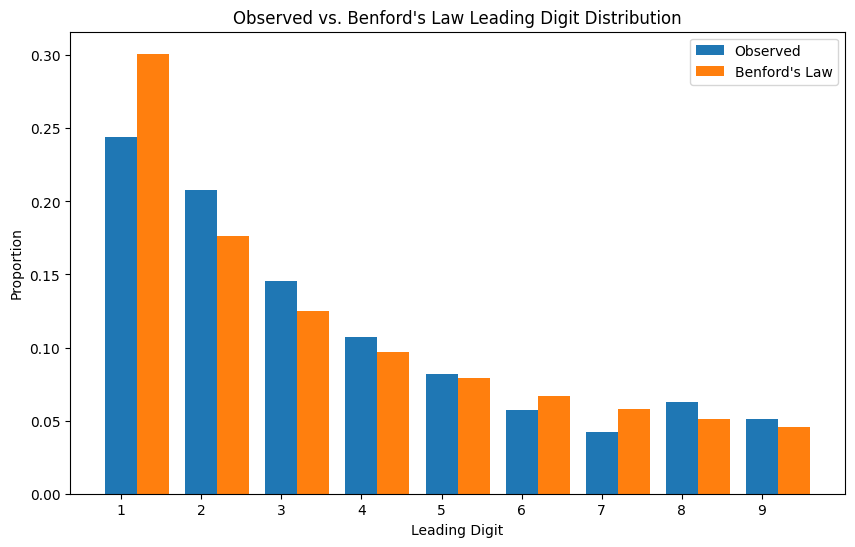

In [ ]:
# Step 5: Visualization: Plot observed vs. expected distribution
plt.figure(figsize=(10, 6))
plt.bar(observed_distribution.index, observed_distribution.values, width=0.4, label="Observed", align='center')
plt.bar(np.arange(1, 10) + 0.4, benford_probabilities, width=0.4, label="Benford's Law", align='center')
plt.xticks(np.arange(1, 10))
plt.xlabel("Leading Digit")
plt.ylabel("Proportion")
plt.title("Observed vs. Benford's Law Leading Digit Distribution")
plt.legend()
plt.show()

In [ ]:
# Step 6: Perform chi-square goodness-of-fit test
# Scale Benford's probabilities to match observed counts
expected_counts = benford_probabilities * observed_counts.sum()
chi2_stat, p_value = chisquare(f_obs=observed_counts, f_exp=expected_counts)
print("")
print("Chi-square Statistic:", chi2_stat)
print("P-value:", p_value)


Chi-square Statistic: 36.441985400389726
P-value: 1.4572473074573346e-05


In [ ]:
# Step 7: Calculate Z-scores to highlight significant deviations
z_scores = (observed_counts - expected_counts) / np.sqrt(expected_counts)

In [ ]:
# Step 8: Create a table summarizing the results
summary_df = pd.DataFrame({
    "Leading Digit": np.arange(1, 10),
    "Observed Count": observed_counts,
    "Expected Count": expected_counts,
    "Observed Proportion": observed_distribution,
    "Benford Proportion": benford_probabilities,
    "Difference (%)": (observed_distribution - benford_probabilities) * 100,
    "Z-score": z_scores
})
summary_df.fillna(0, inplace=True)  # Handle any NaN values
display(summary_df)

,Leading Digit,Observed Count,Expected Count,Observed Proportion,Benford Proportion,Difference (%),Z-score
OBS_VALUE,,,,,,,
1,1,291,359.128785,0.243923,0.301030,-5.710711,-3.595055
2,2,248,210.076872,0.207879,0.176091,3.178804,2.616466
3,3,174,149.051913,0.145851,0.124939,2.091206,2.043471
4,4,128,115.613646,0.107293,0.096910,1.038253,1.151964
5,5,98,94.463227,0.082146,0.079181,0.296460,0.363895
6,6,68,79.867520,0.056999,0.066947,-0.994763,-1.327929
7,7,50,69.184393,0.041911,0.057992,-1.608080,-2.306450
8,8,75,61.024959,0.062867,0.051153,1.171420,1.788955
9,9,61,54.588686,0.051132,0.045757,0.537411,0.867752


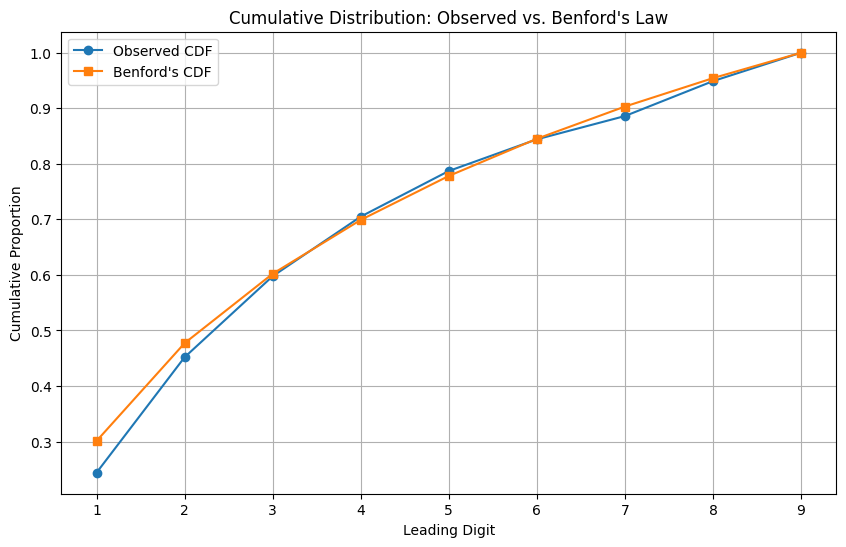

In [ ]:
# Step 9: Plot cumulative distribution comparison
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, 10), observed_distribution.cumsum(), marker='o', label="Observed CDF")
plt.plot(np.arange(1, 10), benford_probabilities.cumsum(), marker='s', label="Benford's CDF")
plt.xlabel("Leading Digit")
plt.ylabel("Cumulative Proportion")
plt.title("Cumulative Distribution: Observed vs. Benford's Law")
plt.legend()
plt.grid()
plt.show()